# Loan Default Prediction in the Fannie Mae Single Family Loan Dataset

## Introduction

What is Fannie Mae? According to Wikipedia, "The Federal National Mortgage Association (FNMA), commonly known as Fannie Mae, is a United States government-sponsored enterprise (GSE) and, since 1968, a publicly traded company. Founded in 1938 during the Great Depression as part of the New Deal, the corporation's purpose is to expand the secondary mortgage market by securitizing mortgages in the form of mortgage-backed securities (MBS), allowing lenders to reinvest their assets into more lending and in effect increasing the number of lenders in the mortgage market by reducing the reliance on locally based savings and loan associations." Fannie Mae releases quarterly based single family fixed rate mortgage dataset on its website. The data is divided into acquisition files and performance files grouped quarterly ranging from year 2000 to 2017. The acquisition files contain static mortgage loan data at the time of the mortgage loan's origination and delivery to Fannie Mae, these files include personal information, loan amount, loan rate and other things. The performance files contain monthly performance data for each loan such as payment information, from acquisition up until its current status as of the previous quarter. If a loan has defaulted, we can see it from the performance files where the last status will print out a foreclosure date. Inspired by Kyle's notebook [see here](https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/), we can utilize the existance of foreclosure date to determine whether a loan is bad, further Kyle has made a baseline model that can predict approximately 90% of the defaulted loan from the 2007Q4 dataset. In this project, I am interested if we can increase some default prediction accuracy, as well as predict the next quarter data from the past.   

## Import and Clean the Dataset

In the project, I would like to 

In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import roc_curve
import seaborn as sns
import pandas as pd
import numpy as np
from ggplot import *
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 50)

C:\Users\TANGP05\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Combined_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
                            ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
                            ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"
                            
                     , "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
                            , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
                            "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
                            "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

Combined_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
                            "float", "str", "float", "float", "str", "str", "str", "str", "str",
                            "str", "str", "float", "str", "float", "float", "str"

                       , "str", "str", "float", "float", "float", "float", "float", "str",
                            "str", "str", "str", "str", "str", "str", "str", "str",
                            "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "str", "float", "str"]

Combined_dict=dict(zip(Combined_Variables,Combined_ColClasses))
# Combined_date_cols=["ORIG_DTE","FRST_DTE","Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]
Combined_date_cols=["ORIG_DTE","FRST_DTE","FCC_DTE"]

Combined_Data= pd.read_csv('Combined_Data_2007Q3.txt', sep='|', 
                    names=Combined_Variables, 
                     dtype=Combined_dict,
                     parse_dates=Combined_date_cols,
                     usecols=list(range(25))+[39],      
                    index_col=False)


In [3]:
Combined_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314723 entries, 0 to 314722
Data columns (total 26 columns):
LOAN_ID           314723 non-null object
ORIG_CHN          314723 non-null object
Seller.Name       314723 non-null object
ORIG_RT           314723 non-null float64
ORIG_AMT          314723 non-null float64
ORIG_TRM          314723 non-null int32
ORIG_DTE          314723 non-null datetime64[ns]
FRST_DTE          314723 non-null datetime64[ns]
OLTV              314723 non-null float64
OCLTV             314723 non-null float64
NUM_BO            314713 non-null object
DTI               305580 non-null float64
CSCORE_B          314084 non-null float64
FTHB_FLG          314723 non-null object
PURPOSE           314723 non-null object
PROP_TYP          314723 non-null object
NUM_UNIT          314723 non-null object
OCC_STAT          314723 non-null object
STATE             314723 non-null object
ZIP_3             314723 non-null object
MI_PCT            55596 non-null float64
Product

In [4]:
# drop_performance=["Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
#                             , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
#                             "ZB_DTE", "LPI_DTE", "DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
#                             "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]
# Combined_Data.drop(drop_performance, axis=1, inplace=True)

In [5]:
Combined_Data['ORIG_VAL']=Combined_Data['ORIG_AMT']/(Combined_Data['OLTV']/100)
Combined_Data['OCLTV']=Combined_Data.apply(lambda row : row['OLTV'] if row['OCLTV']==np.nan else row['OCLTV'],axis=1)

Combined_Data['CSCORE_MN']=Combined_Data.apply(lambda row : min(row['CSCORE_B'],row['CSCORE_C']) ,axis=1)

Combined_Data['VinYr']=Combined_Data['ORIG_DTE'].dt.year
Combined_Data['ORIG_DTE_month']=Combined_Data['ORIG_DTE'].dt.month

Combined_Data['FRST_DTE_year']=Combined_Data['FRST_DTE'].dt.year
Combined_Data['FRST_DTE_month']=Combined_Data['FRST_DTE'].dt.month

In [6]:
drop_acquisition=["LOAN_ID","MI_TYPE","MI_PCT","CSCORE_B","CSCORE_C","Product.Type","ORIG_DTE","FRST_DTE"]
Combined_Data.drop(drop_acquisition, axis=1, inplace=True)

In [7]:
Combined_Data['Default']=Combined_Data['FCC_DTE'].apply(lambda x: 0 if str(x)=='NaT' else 1).astype(int)
Combined_Data.drop(['FCC_DTE'], axis=1, inplace=True)

In [8]:
Combined_Data.groupby(['Seller.Name',"Default"]).size()

Seller.Name                                Default
AMTRUST BANK                               0           8042
                                           1            666
BANK OF AMERICA, N.A.                      0          78618
                                           1           8083
BISHOPS GATE RESIDENTIAL MORTGAGE TRUST    0           3177
                                           1            150
CITIMORTGAGE, INC.                         0          40606
                                           1           2757
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB   0            623
                                           1             15
FIRST TENNESSEE BANK NATIONAL ASSOCIATION  0           7637
                                           1            496
FLAGSTAR CAPITAL MARKETS CORPORATION       0           8186
                                           1            907
GMAC MORTGAGE, LLC                         0          16866
                                           1     

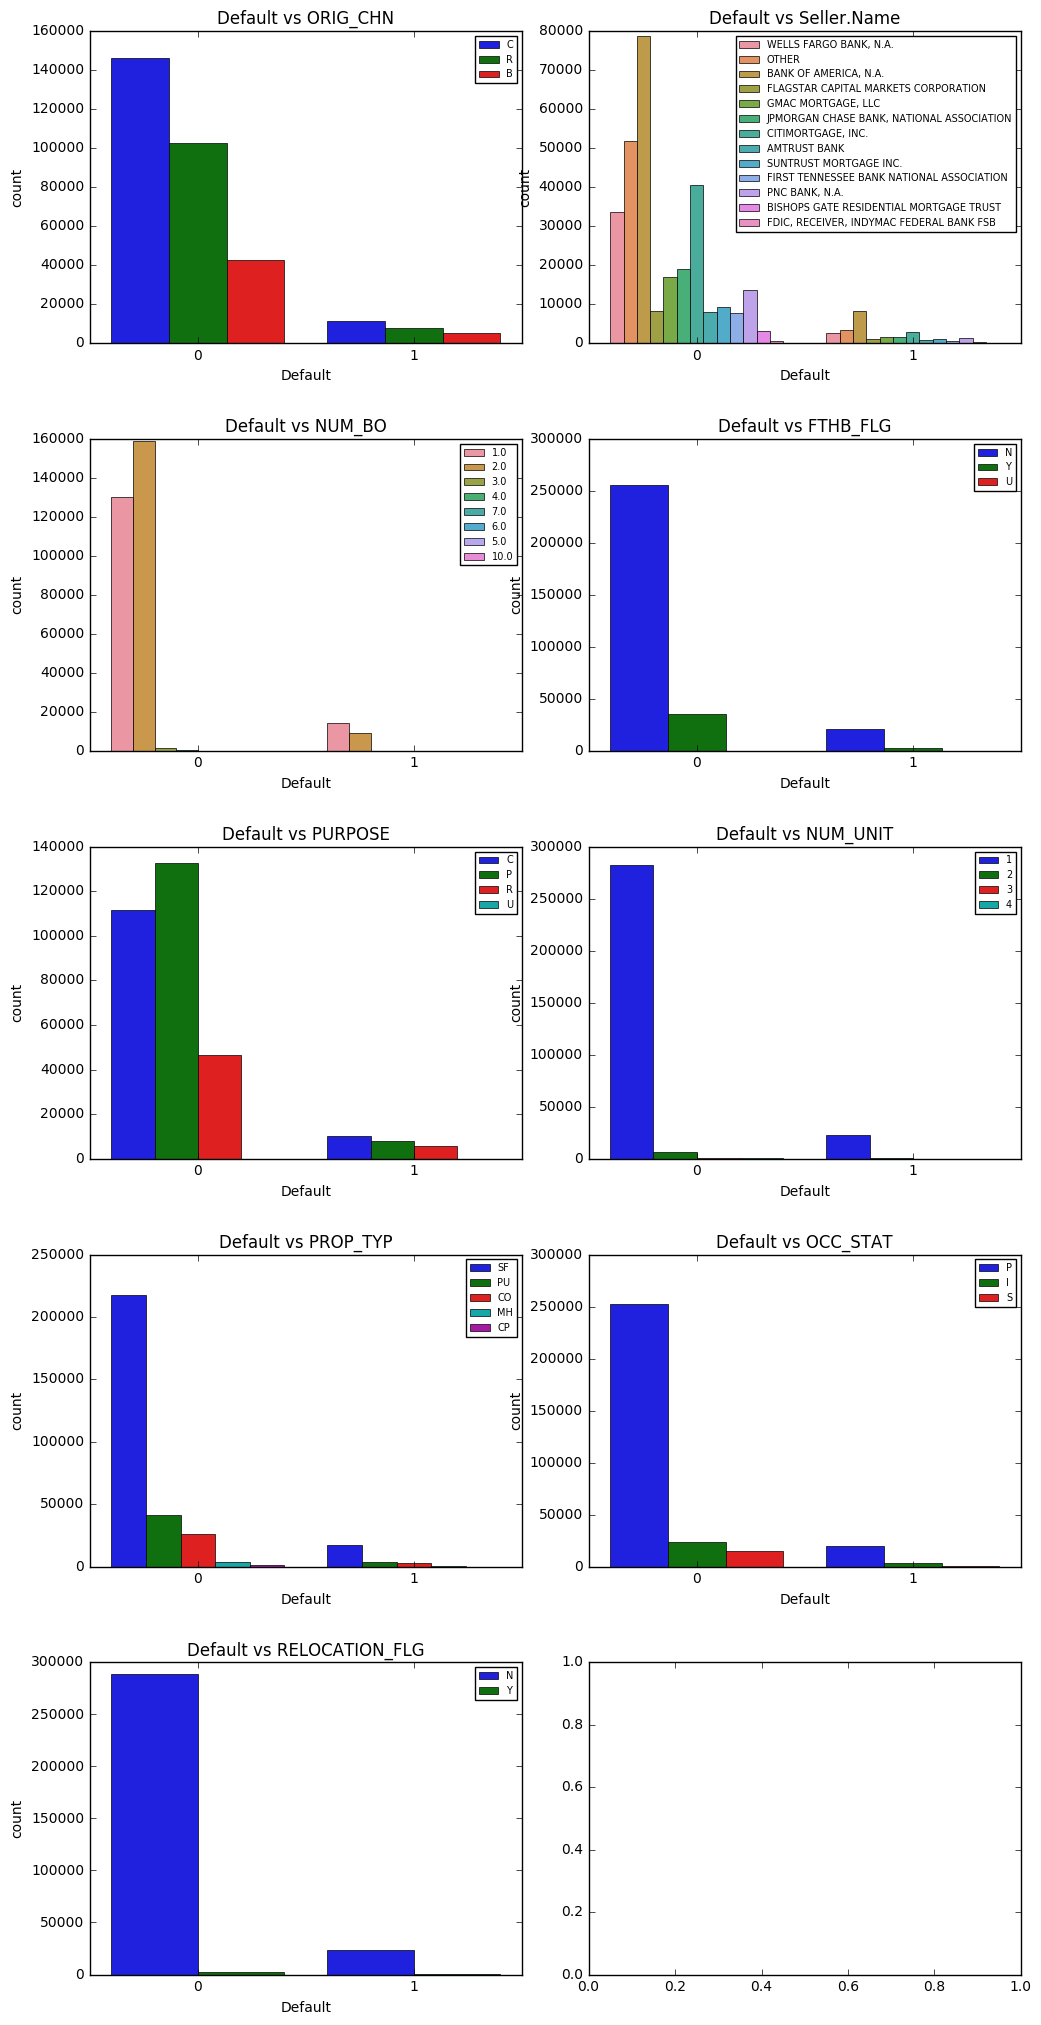

In [9]:
columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE","NUM_UNIT","PROP_TYP","OCC_STAT","RELOCATION_FLG"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,10), columns):
    plt.subplot(5,2,i)
    ax=sns.countplot(x="Default", hue=column, data=Combined_Data, linewidth=0.5)

    ax.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
# plt.legend(loc="upper right",fontsize="xx-small")


C:\Users\TANGP05\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


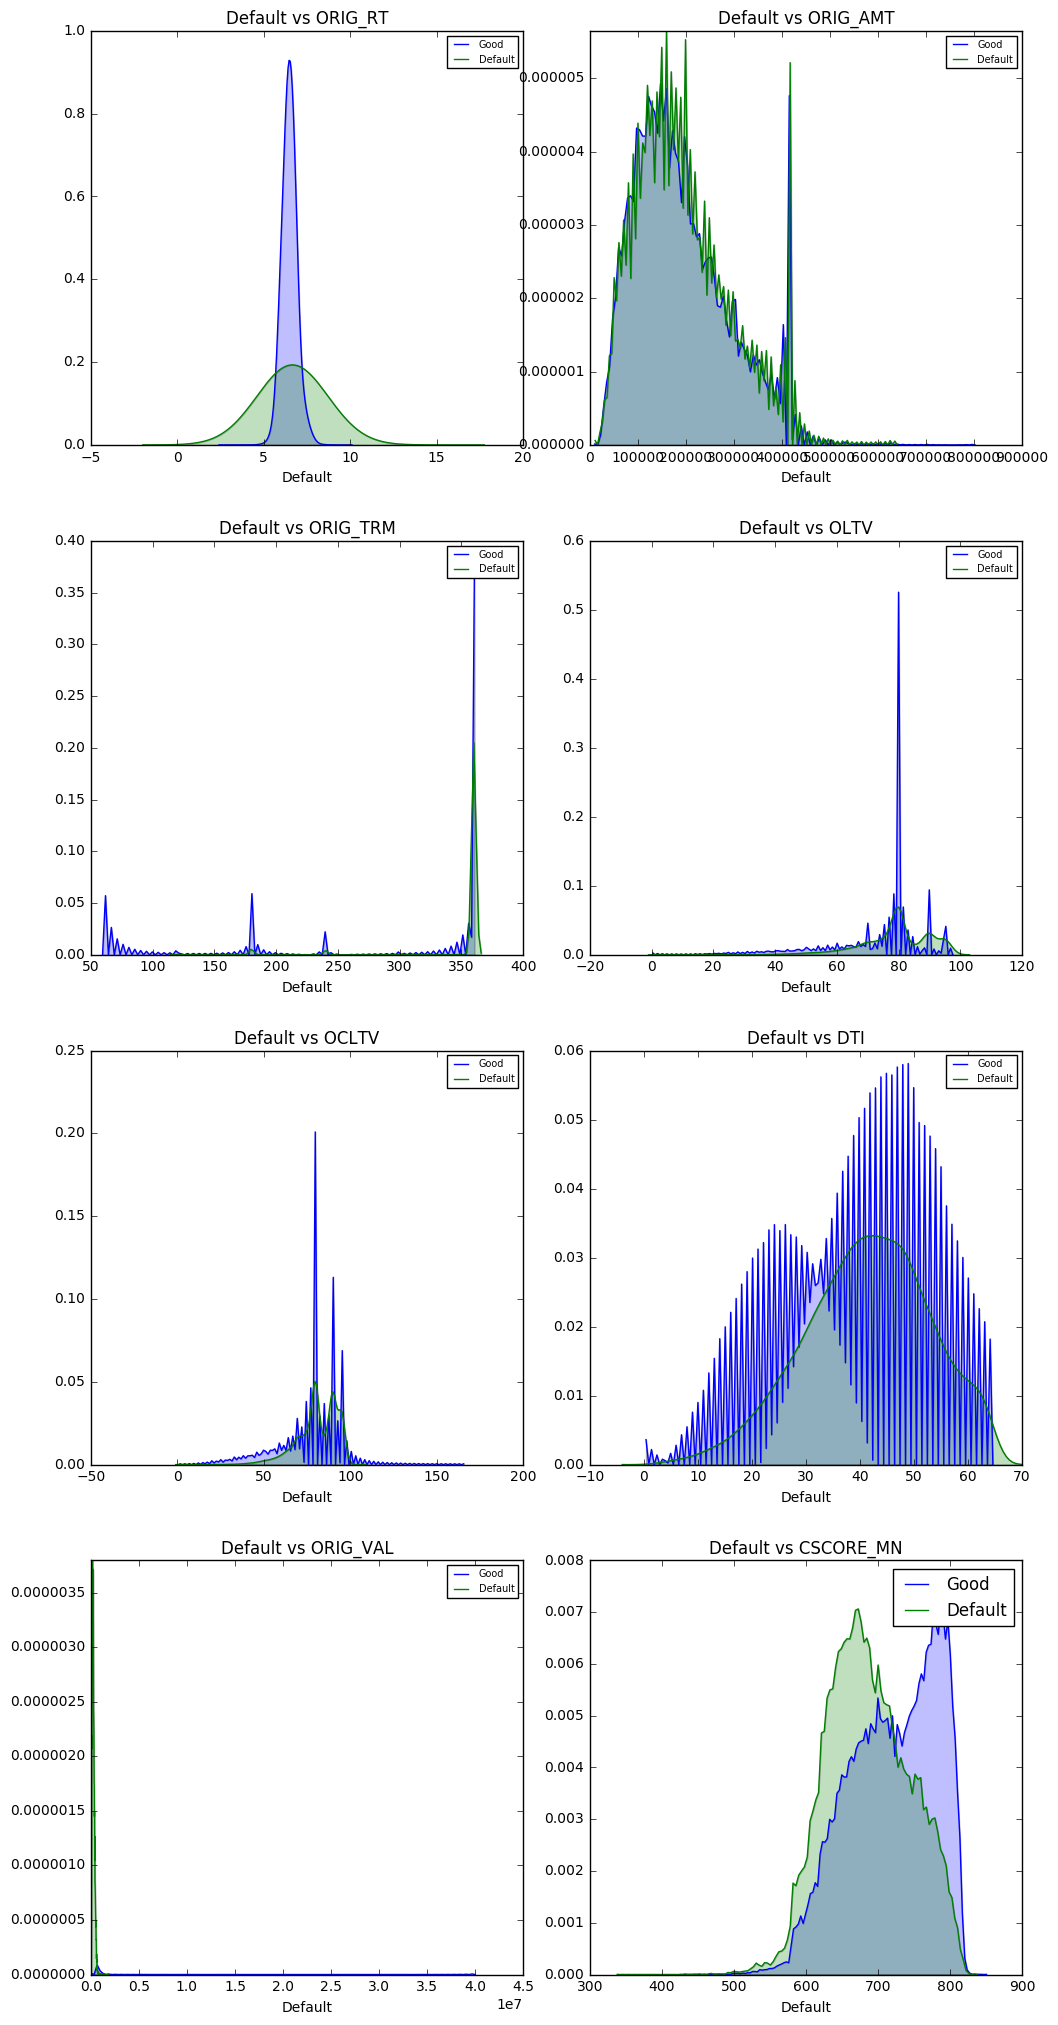

In [10]:
columns = ["ORIG_RT","ORIG_AMT","ORIG_TRM","OLTV","OCLTV","DTI","ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Good",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
plt.legend()

In [11]:
Combined_Data['log_ORIG_VAL']=np.log(Combined_Data['ORIG_VAL'])
Combined_Data['log_ORIG_AMT']=np.log(Combined_Data['ORIG_AMT'])
Combined_Data['sqrt_OLTV']=np.sqrt(Combined_Data['OLTV'])
Combined_Data['log_ORIG_TRM']=-np.log(Combined_Data['ORIG_TRM'])
Combined_Data['log_OCLTV']=np.log(Combined_Data['OCLTV'])
Combined_Data['log_DTI']=np.log(Combined_Data['DTI'])

C:\Users\TANGP05\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


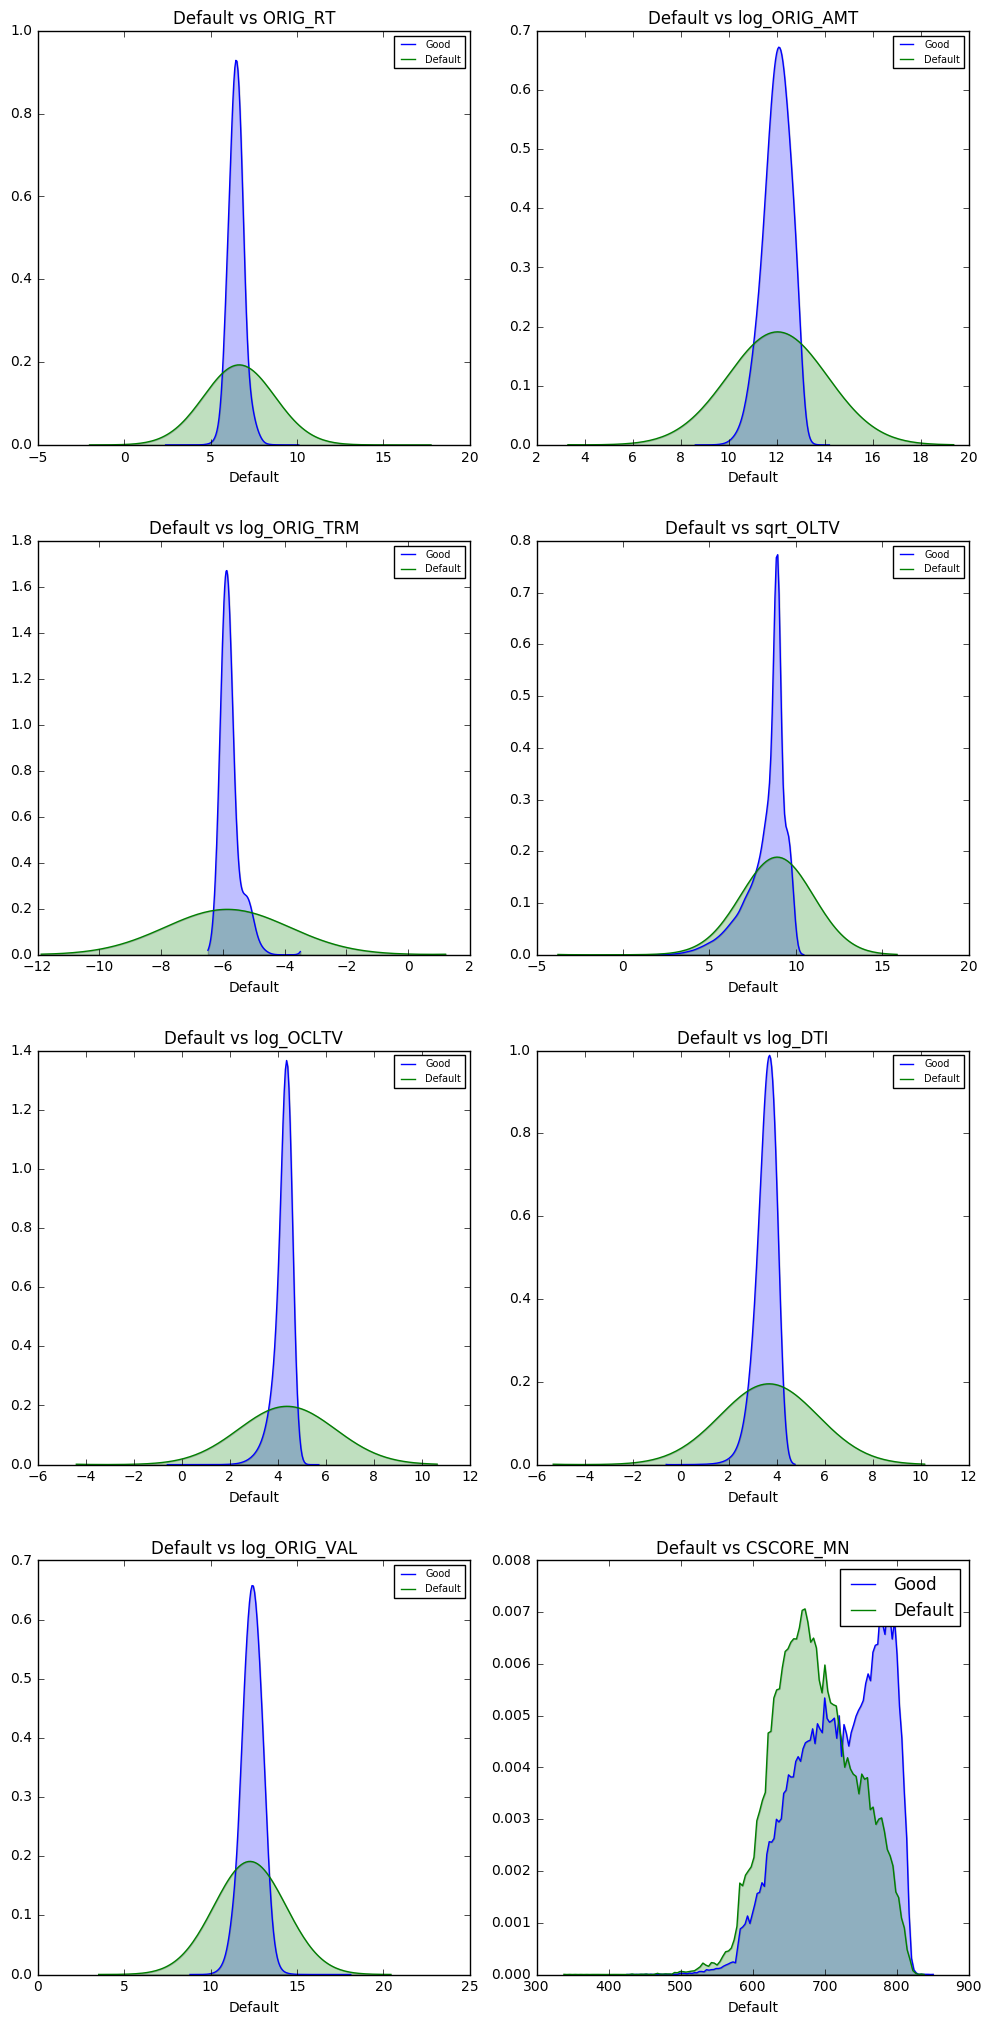

In [67]:
columns = ["ORIG_RT","log_ORIG_AMT","log_ORIG_TRM","sqrt_OLTV","log_OCLTV","log_DTI","log_ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Good",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
plt.legend()

In [37]:
df=Combined_Data.groupby(['STATE','Default']).size()
df2=df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
df2=df2[df2['Default']==1].sort_values(by=[0],ascending=False)

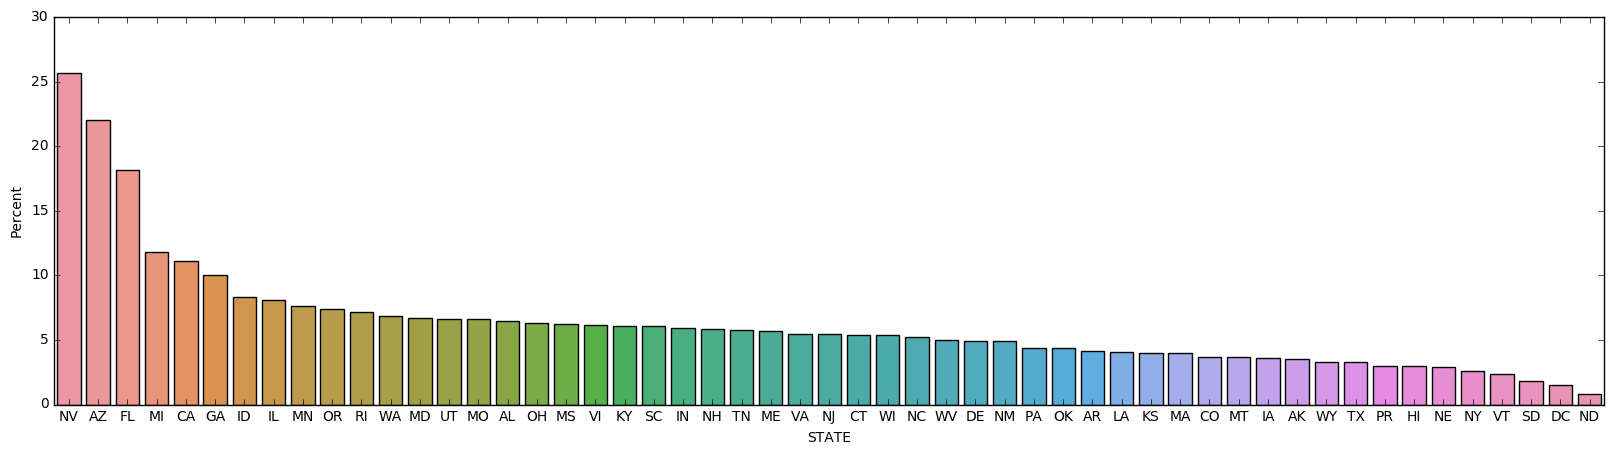

In [45]:
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x="STATE",y=0, data=df2)
ax.set(ylabel="Percent")

In [68]:
# columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
#            "NUM_UNIT","PROP_TYP","STATE","ZIP_3",'RELOCATION_FLG','OCC_STAT']

columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
           "NUM_UNIT","PROP_TYP","STATE","ZIP_3",'RELOCATION_FLG','OCC_STAT',
           "ORIG_DTE_month","FRST_DTE_year","FRST_DTE_month",'VinYr']

for column in columns:
    temp=pd.get_dummies(Combined_Data[column],prefix=column,drop_first =True)
    Combined_Data = pd.concat([Combined_Data,temp],axis=1)
    Combined_Data = Combined_Data.drop([column], axis=1)

In [69]:
# final drop
# columns=["ORIG_DTE_month","FRST_DTE_year","FRST_DTE_month",'VinYr',
#           'ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL']

columns=['ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL']

Combined_Data.drop(columns, axis=1, inplace=True)

# Prediction

In [70]:
Train, Test = train_test_split(Combined_Data, test_size = 0.2)

X_train = Train.drop(['Default'], axis=1)
Y_train = Train["Default"]
del Train

X_test = Test.drop(['Default'], axis=1)
Y_test = Test['Default']
del Test

In [72]:
dtrain = xgb.DMatrix(X_train, label=Y_train)

dvalid = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


In [74]:
xgb_pars = {'min_child_weight': 5, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 15,
'subsample': 0.9, 'lambda': 0.1, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'objective': 'binary:logistic','seed':1234}

#xgb_pars = {'min_child_weight': 1, 'eta': 1, 'colsample_bytree': 0.9, 
#            'max_depth': 10,
#'subsample': 0.9, 'lambda': 30, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#'eval_metric': 'rmse', 'objective': 'reg:linear'}

#xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
#            'max_depth': 20,
#'subsample': 0.9, 'lambda': 10, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#'eval_metric': 'rmse', 'objective': 'reg:linear','seed' : 1234}

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'roc', -area


model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1,feval=evalauc)
print('Modeling AUPRC %.5f' % model.best_score)

[0]	train-error:0.072727	valid-error:0.080245	train-roc:0.355707	valid-roc:0.226837
Multiple eval metrics have been passed: 'valid-roc' will be used for early stopping.

Will train until valid-roc hasn't improved in 5 rounds.
[1]	train-error:0.070757	valid-error:0.077258	train-roc:0.412607	valid-roc:0.24565
[2]	train-error:0.069478	valid-error:0.076781	train-roc:0.440311	valid-roc:0.255974
[3]	train-error:0.068167	valid-error:0.076765	train-roc:0.480451	valid-roc:0.256161
[4]	train-error:0.067881	valid-error:0.076321	train-roc:0.496568	valid-roc:0.257677
[5]	train-error:0.067003	valid-error:0.076734	train-roc:0.511292	valid-roc:0.258744
Stopping. Best iteration:
[0]	train-error:0.072727	valid-error:0.080245	train-roc:0.355707	valid-roc:0.226837

Modeling AUPRC 0.22684


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, average_precision_score,f1_score,fbeta_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split,StratifiedKFold

In [23]:
def fillnan(df):
    columns = df.columns[df.isnull().any()]
    for name in columns:
        y = df.loc[df[name].notnull(), name].values
        X = df.loc[df[name].notnull()].drop(columns, axis=1).values
        X_test = df.loc[df[name].isnull()].drop(columns, axis=1).values
        if df[name].dtypes == 'object':
            model = RandomForestClassifier(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
        else:
            model = RandomForestRegressor(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
    return df

In [24]:
Combined_Data2 = fillnan(Combined_Data)

In [32]:
Combined_Data.columns[:30]

Index(['ORIG_RT', 'CSCORE_MN', 'Default', 'log_ORIG_VAL', 'log_ORIG_AMT',
       'sqrt_OLTV', 'log_ORIG_TRM', 'log_OCLTV', 'log_DTI', 'ORIG_CHN_C',
       'ORIG_CHN_R', 'Seller.Name_BANK OF AMERICA, N.A.',
       'Seller.Name_BISHOPS GATE RESIDENTIAL MORTGAGE TRUST',
       'Seller.Name_CITIMORTGAGE, INC.',
       'Seller.Name_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB',
       'Seller.Name_FIRST TENNESSEE BANK NATIONAL ASSOCIATION',
       'Seller.Name_FLAGSTAR CAPITAL MARKETS CORPORATION',
       'Seller.Name_GMAC MORTGAGE, LLC',
       'Seller.Name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION',
       'Seller.Name_OTHER', 'Seller.Name_PNC BANK, N.A.',
       'Seller.Name_SUNTRUST MORTGAGE INC.',
       'Seller.Name_WELLS FARGO BANK, N.A.', 'NUM_BO_10.0', 'NUM_BO_2.0',
       'NUM_BO_3.0', 'NUM_BO_4.0', 'NUM_BO_5.0', 'NUM_BO_6.0', 'NUM_BO_7.0'],
      dtype='object')

In [25]:
X=Combined_Data2.iloc[:,Combined_Data2.columns != 'Default'].as_matrix()
y=Combined_Data2['Default'].as_matrix()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y

In [27]:
layers=(10,10,10,10)
learning_rate_init=0.001
alpha=0.0001

#clf = MLPClassifier(solver='adam',activation='tanh',hidden_layer_sizes=layers, learning_rate='adaptive',learning_rate_init=lr_init,alpha=alpha,random_state=2)
clf = MLPClassifier(solver='adam',activation='tanh',
                    hidden_layer_sizes=layers, learning_rate='adaptive',
                    learning_rate_init=learning_rate_init,alpha=alpha,random_state=2345,
                    max_iter=200,verbose=10)

In [28]:
scorings ='average_precision'
fold=5
cv=StratifiedKFold(n_splits=fold,random_state=1234)

scores=cross_validate(clf,X_train,y_train,cv=cv,scoring=scorings,return_train_score=True)
print(scores)

Iteration 1, loss = 0.27121412
Iteration 2, loss = 0.26808400
Iteration 3, loss = 0.26807694
Iteration 4, loss = 0.26807722
Iteration 5, loss = 0.26806563
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27118640
Iteration 2, loss = 0.26809932
Iteration 3, loss = 0.26808968
Iteration 4, loss = 0.26807007
Iteration 5, loss = 0.26807442
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27121781
Iteration 2, loss = 0.26806039
Iteration 3, loss = 0.26811043
Iteration 4, loss = 0.26808761
Iteration 5, loss = 0.26807290
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27111727
Iteration 2, loss = 0.26807990
Iteration 3, loss = 0.26809324
Iteration 4, loss = 0.26806681
Iteration 5, loss = 0.26808593
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, los

In [36]:
Combined_Data['log_ORIG_VAL']=np.log(Combined_Data['ORIG_VAL'])

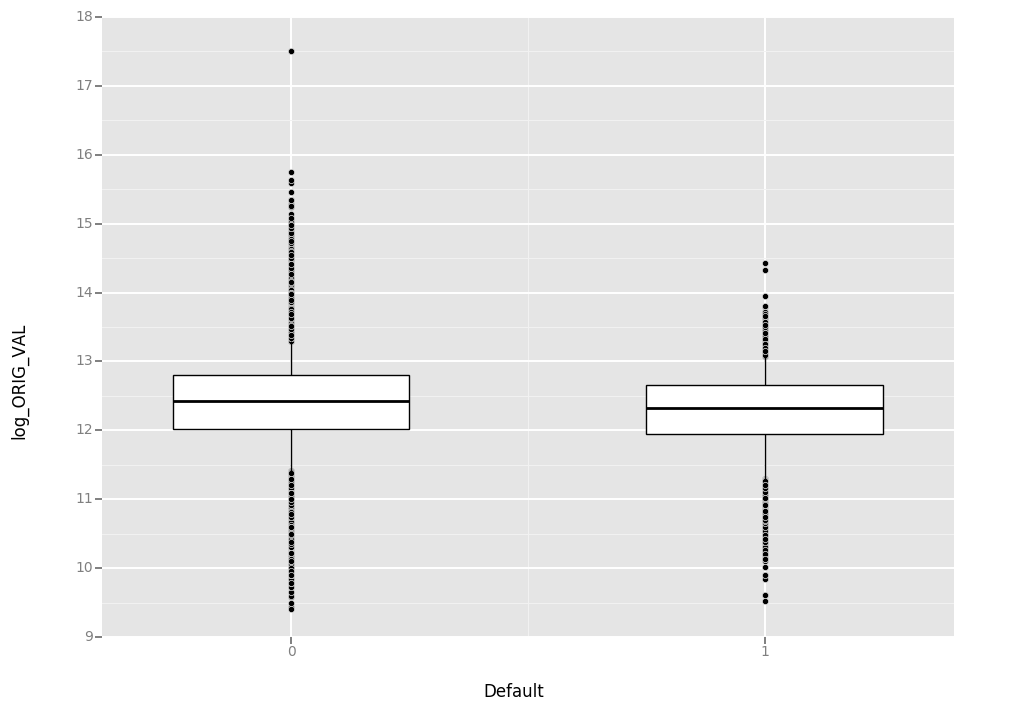

<ggplot: (134801002465)>

In [30]:
ggplot(aes(x='Default',y='log_ORIG_VAL'),data=Combined_Data)+geom_boxplot()

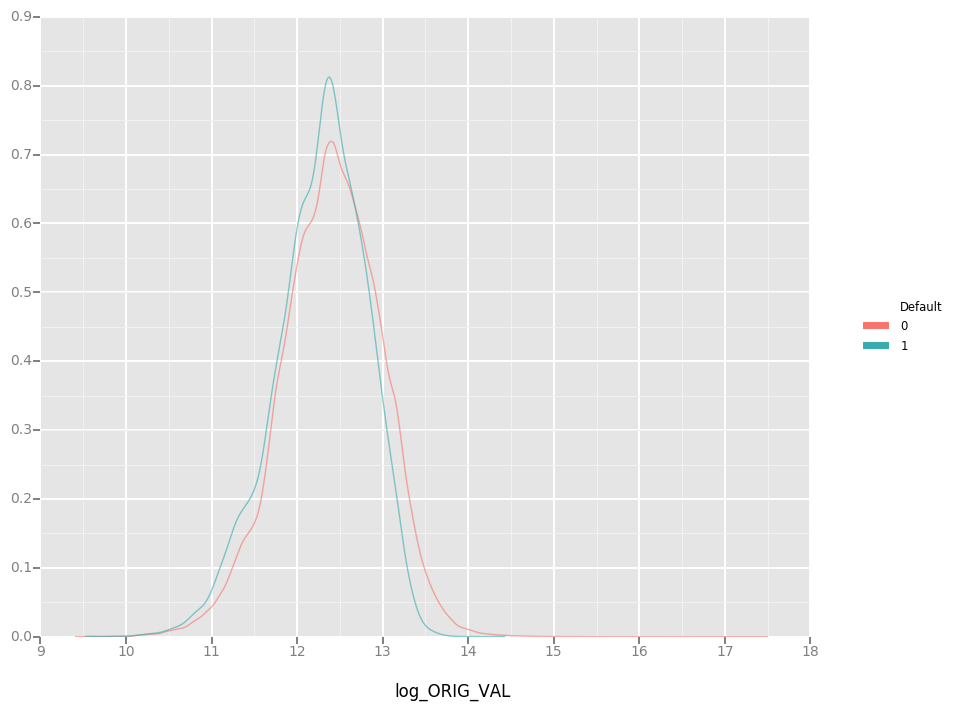

<ggplot: (-9223371901831369910)>

In [62]:
ggplot(aes(x='log_ORIG_VAL',color='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)

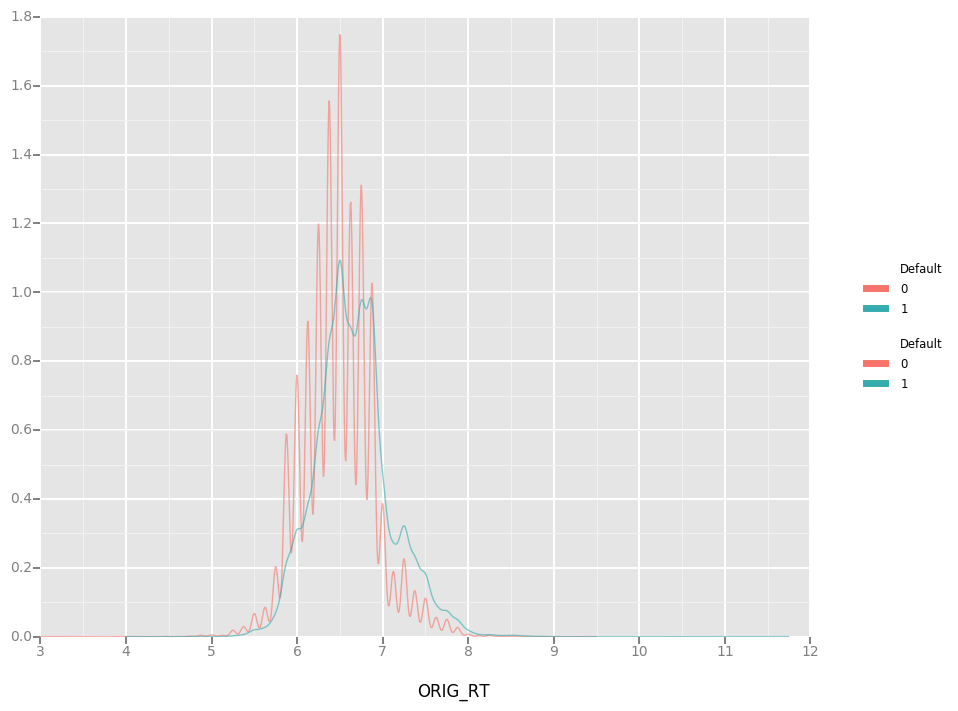

<ggplot: (-9223371902089763924)>

In [41]:
ggplot(aes(x='ORIG_RT',color='Default',fill='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)

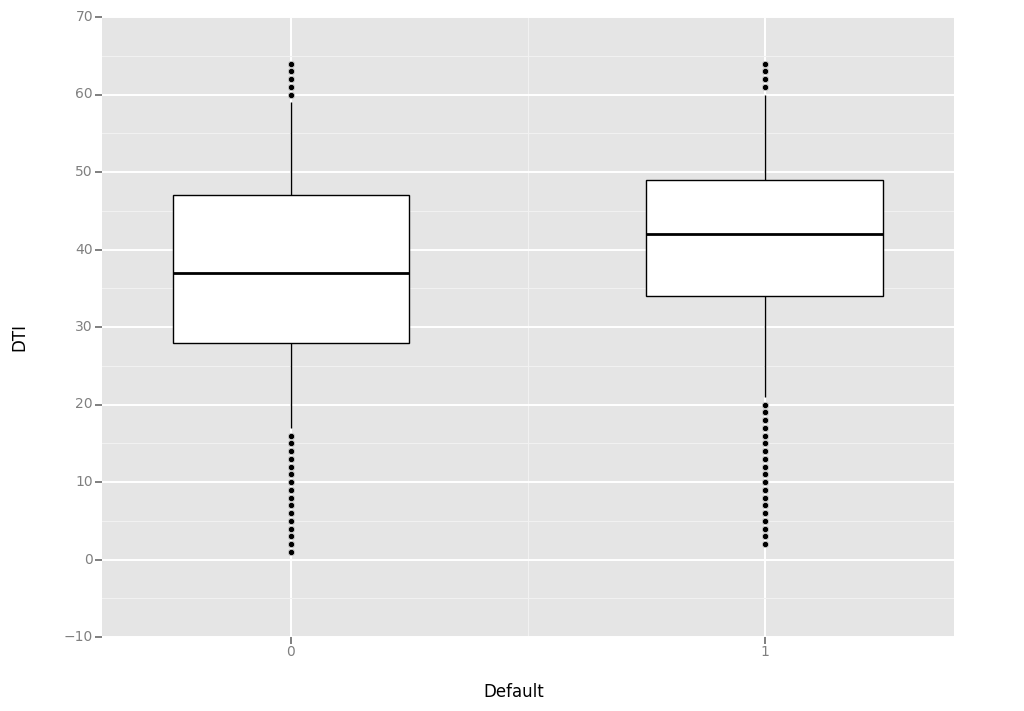

<ggplot: (135007511360)>

In [60]:
ggplot(aes(x='Default',y='DTI'),data=Combined_Data[Combined_Data['DTI'].notnull()])+geom_boxplot()

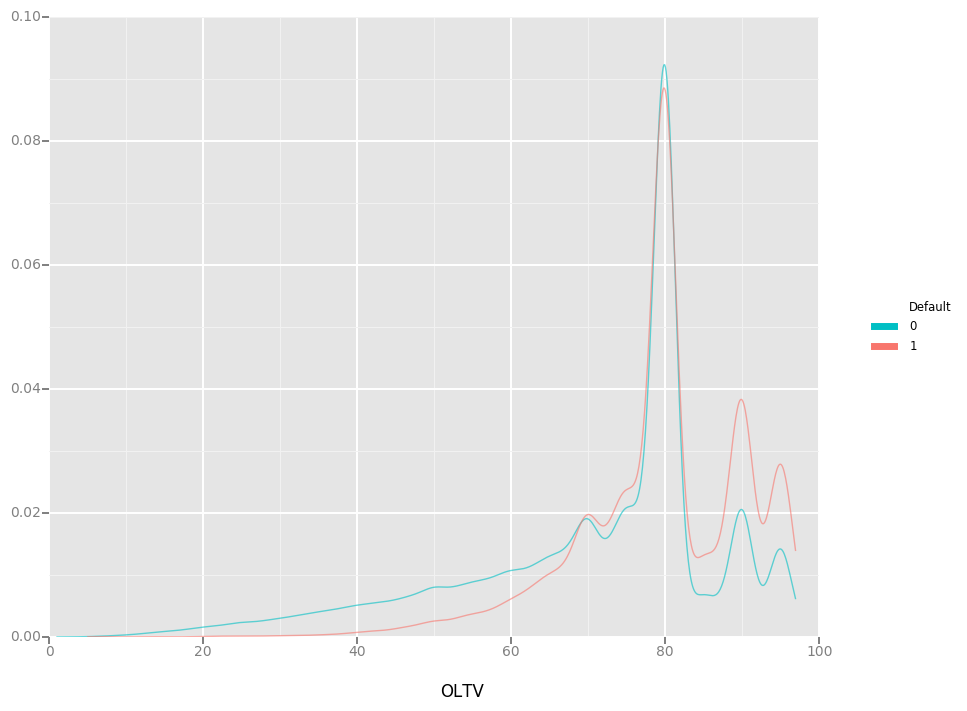

<ggplot: (134961319039)>

In [54]:
ggplot(aes(x='OLTV',color='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)+ \
scale_color_manual(values = ["#00BFC4","#F8766D"])

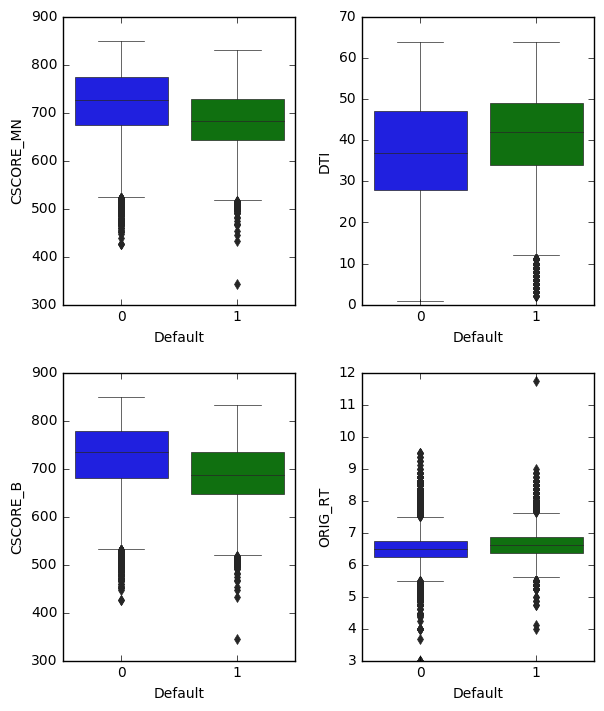

In [19]:
columns = ['CSCORE_MN','DTI','CSCORE_B','ORIG_RT']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(6,7))
mp.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1,5), columns):
    mp.subplot(2,2,i)
    sns.boxplot(x="Default", y=column, data=Combined_Data, linewidth=0.5)
    mp.xlabel('Default')

C:\Users\TANGP05\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


ValueError: zero-size array to reduction operation minimum which has no identity

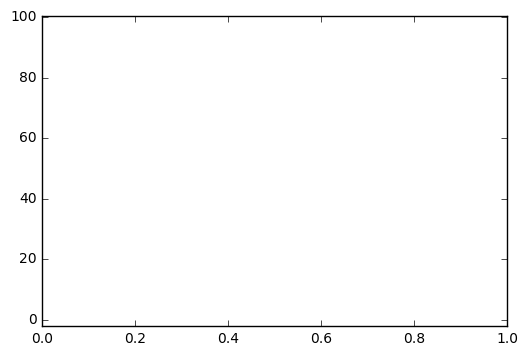

In [51]:

sns.kdeplot(Combined_Data["Default"], Combined_Data["OLTV"], linewidth=0.5)